In [7]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version


path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

Anzahl Zeilen: 1296675
Anzahl Spalten: 24


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

y = ds["is_fraud"]
X = ds[["trans_date_trans_time", "merchant", "category", "amt", "state", "job", "dob"]]

# Datenvorbereitung
X["trans_date_trans_time"] = pd.to_datetime(X["trans_date_trans_time"])
X["dob"] = pd.to_datetime(X["dob"])

X["trans_year"] = X["trans_date_trans_time"].dt.year
X["trans_month"] = X["trans_date_trans_time"].dt.month
X["trans_day"] = X["trans_date_trans_time"].dt.day
X["trans_hour"] = X["trans_date_trans_time"].dt.hour

X["birth_year"] = X["dob"].dt.year
X["age"] = X["trans_year"] - X["birth_year"]

X = X.drop(columns=["trans_date_trans_time", "dob"])

categorical_features = ["merchant", "category", "state", "job"]
numeric_features = ["amt", "trans_year", "trans_month", "trans_day", "trans_hour", "age"]

# One-Hot-Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"  # lässt numerische Spalten unverändert
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_51496/2506800533.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["trans_date_trans_time"] = pd.to_datetime(X["trans_date_trans_time"])
/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_51496/2506800533.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["dob"] = pd.to_datetime(X["dob"])
/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_51496/2506800533.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy 

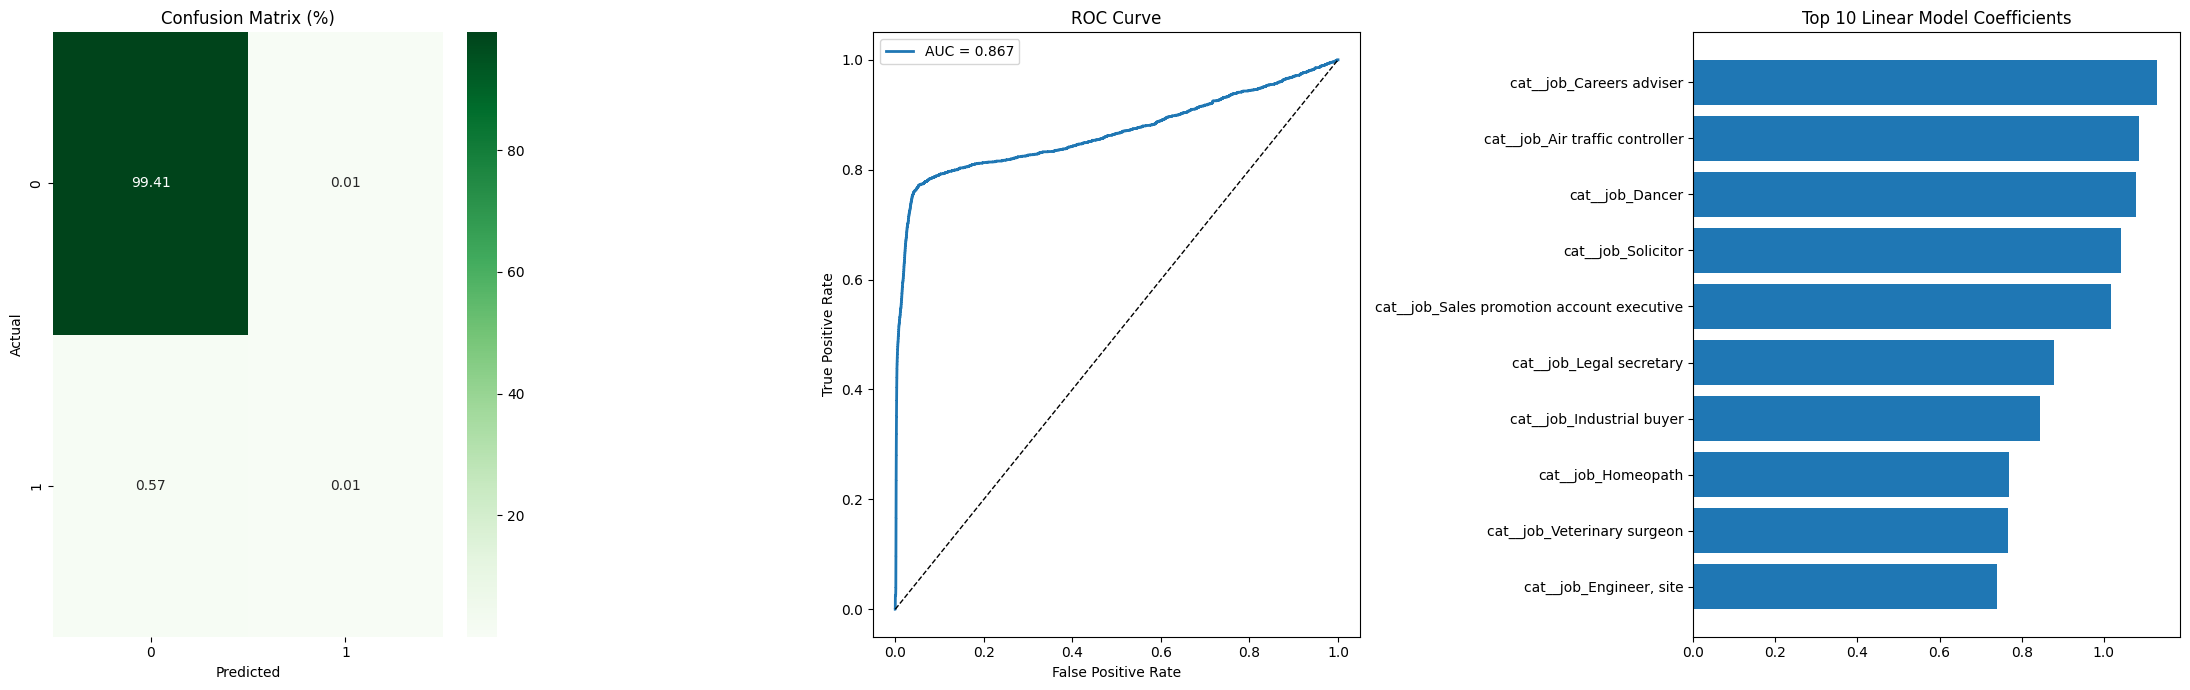

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# -----------------------------
# 1️⃣ Prediction + Thresholding
# -----------------------------
y_prob = model.predict(X_test)                   # continuous output
y_pred = (y_prob >= 0.5).astype(int)             # convert to class labels

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum() * 100

# -----------------------------
# 2️⃣ ROC Curve Daten
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

# -----------------------------
# 3️⃣ Feature Importance (Regression Coefficients)
# -----------------------------
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
coef = model.named_steps["classifier"].coef_

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})

# sort by absolute weight
feat_imp = feat_imp.reindex(feat_imp.Coefficient.abs().sort_values(ascending=False).index)
top_feat = feat_imp.head(10)

# -----------------------------
# 4️⃣ Figure mit 3 Subplots
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# --- Confusion Matrix ---
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", ax=axes[0])
axes[0].set_title("Confusion Matrix (%)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# --- ROC Kurve ---
axes[1].plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", linewidth=2)
axes[1].plot([0,1], [0,1], "k--", linewidth=1)
axes[1].set_title("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()

# --- Feature Importance ---
axes[2].barh(top_feat["Feature"], top_feat["Coefficient"])
axes[2].invert_yaxis()
axes[2].set_title("Top 10 Linear Model Coefficients")

plt.tight_layout()
plt.show()

## Multiple Lineare Regression

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from math import radians, sin, cos, sqrt, atan2
# -----------------------------
# 1) Daten vorbereiten und Feature Engineering
# -----------------------------
y = ds["is_fraud"].copy()
# cc_num wird temporär für die Aggregation benötigt
X = ds[["trans_date_trans_time", "cc_num", "merchant", "category", "amt", "state", 
       "lat", "long", "merch_lat", "merch_long", "job", "dob"]].copy()

# Datumsfelder konvertieren
X["trans_date_trans_time"] = pd.to_datetime(X["trans_date_trans_time"])
X["dob"] = pd.to_datetime(X["dob"])

# Kritisch: Nach Zeit sortieren und Index zurücksetzen (für Rolling und CV)
X = X.sort_values("trans_date_trans_time").reset_index(drop=True)


# --- Haversine Distanz Funktion ---
def haversine(lat1, lon1, lat2, lon2):
    """Berechnet die Haversine-Distanz zwischen zwei geografischen Punkten in Kilometern."""
    R = 6371  # Erdradius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

# Anwendung der Funktion
X["distance_km"] = X.apply(
    lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]),
    axis=1
)

X = X.drop(columns=["lat", "long", "merch_lat", "merch_long"])


# --- First Differences (FD) ---
print("Erstelle First Differences Features...")
X['delta_amt'] = X.groupby('cc_num')['amt'].diff().fillna(0)
X['delta_distance_km'] = X.groupby('cc_num')['distance_km'].diff().fillna(0)

# --- Burst Rate ---
# 1. Temporärer DataFrame für die Rolling-Berechnung
X_temp_for_rolling = X.copy().set_index("trans_date_trans_time")

# 2. Berechnung der Burst Rate
# .count() auf 'amt' zählt alle Einträge im Fenster.
burst_rate_series = (
    X_temp_for_rolling.groupby("cc_num")
    .rolling(window="24h", closed="left")
    ["amt"].count() 
    .rename('burst_rate_1d')
)
# Die resultierende Series 'burst_rate_series' hat einen MultiIndex (cc_num, trans_date_trans_time)


# 3. Zuweisung zum Haupt-DataFrame X
# Wir setzen den MultiIndex in X als temporäre Spalten, um das Merge zu erleichtern.
X = X.set_index(['cc_num', 'trans_date_trans_time'])

# Führe den Join durch
X = X.join(burst_rate_series)

# Index wiederherstellen und temporäre Spalten entfernen
X = X.reset_index()

# 4. NaNs füllen (Kunden, die in den letzten 24h keine Transaktion hatten)
X['burst_rate_1d'] = X['burst_rate_1d'].fillna(0)

# --- Weitere Zeit- und Altersfeatures ---
X["trans_year"] = X["trans_date_trans_time"].dt.year
X["trans_month"] = X["trans_date_trans_time"].dt.month
X["weekday"] = X["trans_date_trans_time"].dt.weekday
X["trans_hour"] = X["trans_date_trans_time"].dt.hour

# Altersberechnung
X["birth_year"] = X["dob"].dt.year
X["age"] = X["trans_year"] - X["birth_year"]

# unnötiges entfernen
# cc_num wird jetzt entfernt, da die Aggregation abgeschlossen ist
X = X.drop(columns=["trans_date_trans_time", "dob", "birth_year", "cc_num"])

if len(X) > len(y):
    X = X.reset_index(drop=True)
    # 2. Identifiziere Duplikate (basierend auf allen Spalten außer der Burst Rate, da sie neu ist)
    cols_to_check = X.columns.drop(['burst_rate_1d'])
    X_original_size = X.drop_duplicates(subset=cols_to_check, keep='first')
    X = X_original_size.copy()


# -----------------------------
# 2) Preprocessing
# -----------------------------
categorical_features = ["merchant", "category", "state", "job", "weekday"]
numeric_features = ["amt", "trans_year", "trans_month", "trans_hour", "age", "distance_km", "burst_rate_1d"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="passthrough"
)


Erstelle First Differences Features...


**Exploring Multikollinearität** 

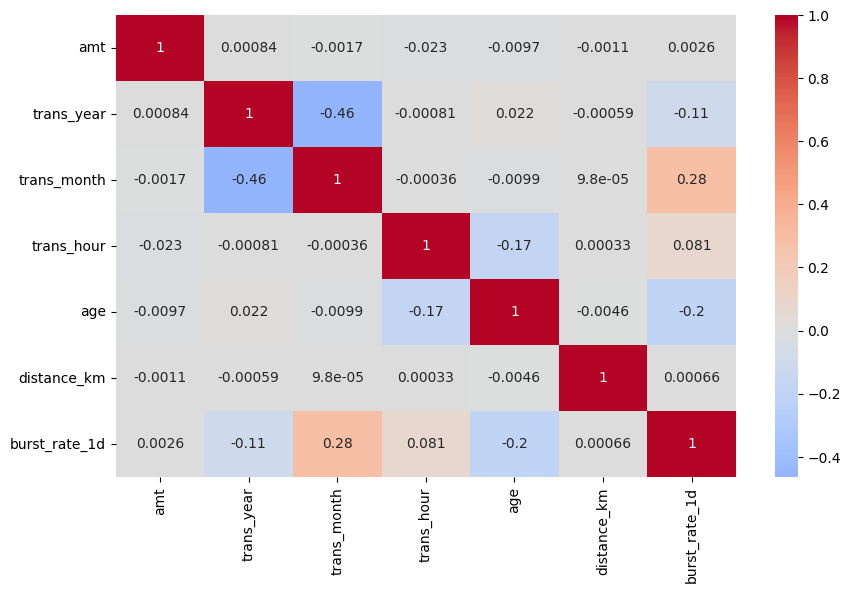

In [10]:
corr = X[numeric_features].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=True)
plt.show()

*Variance Infaltion Factor (VIF)*

Misst, wie stark Varianz eines Koeffizienten durch Multikollinearität aufgebläht wird.

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_for_vif = X[numeric_features]

# VIF DataFrame vorbereiten
vif_df = pd.DataFrame()
vif_df["feature"] = X_for_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

# Sortieren nach höchster Multikollinearität
vif_df = vif_df.sort_values("VIF", ascending=False)

vif_df

,feature,VIF
1,time_index,23.7326
3,age,8.5615
4,distance_km,7.8337
2,trans_hour,4.6808
5,burst_rate_1d,2.7003
0,amt,1.1934


In [14]:
# Entwickeln eines kombinierten Zeitindexs für trans_year und trans_month
X["time_index"] = X["trans_year"] * 12 + X["trans_month"]
X.drop(columns=["trans_year","trans_month"])

,merchant,category,amt,state,job,distance_km,delta_amt,delta_distance_km,burst_rate_1d,weekday,trans_hour,age,time_index
0,"fraud_Rippin, Kub and Mann",misc_net,4.9700,NC,"Psychologist, counselling",78.5976,0.0000,0.0000,0.0000,1,0,31,24229
1,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.2300,WA,Special educational needs teacher,30.2122,0.0000,0.0000,0.0000,1,0,41,24229
2,fraud_Lind-Buckridge,entertainment,220.1100,ID,Nature conservation officer,108.2061,0.0000,0.0000,0.0000,1,0,57,24229
3,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.0000,MT,Patent attorney,95.6732,0.0000,0.0000,0.0000,1,0,52,24229
4,fraud_Keeling-Crist,misc_pos,41.9600,VA,Dance movement psychotherapist,77.5567,0.0000,0.0000,0.0000,1,0,33,24229
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296710,fraud_Reichel Inc,entertainment,15.5600,UT,Geoscientist,119.7521,-47.8500,35.5374,3.0000,6,12,59,24246
1296711,fraud_Abernathy and Sons,food_dining,51.7000,MD,"Production assistant, television",75.1041,-82.6800,30.4816,1.0000,6,12,41,24246
1296712,fraud_Stiedemann Ltd,food_dining,105.9300,NM,Naval architect,99.0477,103.7800,17.9113,3.0000,6,12,53,24246
1296713,"fraud_Reinger, Weissnat and Strosin",food_dining,74.9000,SD,Volunteer coordinator,84.6277,-50.6100,33.0589,0.0000,6,12,40,24246


,feature,VIF
4,distance_km,1.9876
7,delta_distance_km,1.9875
0,amt,1.8887
6,delta_amt,1.8878
3,age,1.0697
5,burst_rate_1d,1.0501
2,trans_hour,1.0339
1,time_index,1.0069


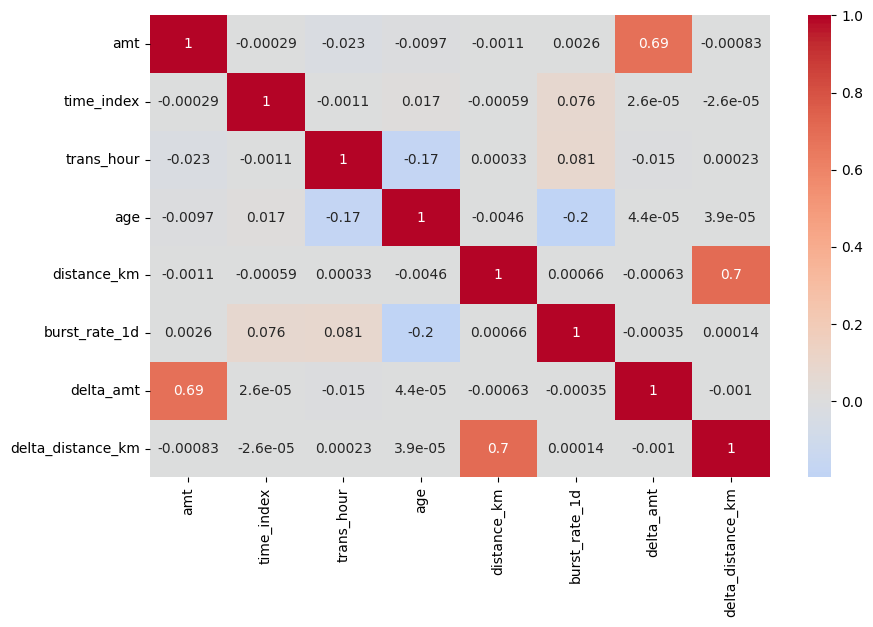

In [15]:
numeric_features = ["amt", "time_index", "trans_hour", "age","distance_km","burst_rate_1d",'delta_amt','delta_distance_km']

# StandardScaler direkt auf die neuen numerischen Features fitten
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X[numeric_features])

# In DataFrame zurückwandeln
X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numeric_features, index=X.index)

# VIF berechnen
vif_df = pd.DataFrame()
vif_df["feature"] = numeric_features
vif_df["VIF"] = [variance_inflation_factor(X_numeric_scaled, i) for i in range(X_numeric_scaled.shape[1])]
vif_df = vif_df.sort_values("VIF", ascending=False)
display(vif_df)

# Korrelation der standardisierten Features
corr_scaled = X_numeric_scaled_df.corr()
sns.heatmap(corr_scaled, cmap="coolwarm", center=0, annot=True)
plt.show()

In [16]:
from sklearn.metrics import make_scorer, average_precision_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="passthrough"
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        class_weight="balanced", 
        solver="liblinear", 
        random_state=42,
        max_iter=500
    ))
])

ap_scorer = make_scorer(average_precision_score, needs_proba=True)
# --- TimeSeries Split ---
# 5 Folds zur Überprüfung der zeitlichen Stabilität
tscv = TimeSeriesSplit(n_splits=5)

# --- Ausführung der Cross-Validation ---
print("\nStarte TimeSeries Cross-Validation...")

cv_results = cross_val_score(
    estimator=pipeline,
    X=X, # Gesamter Feature-Satz
    y=y, # Gesamte Zielvariable
    cv=tscv, # Die TimeSeriesSplit-Strategie
    scoring=ap_scorer, # Die Metrik (Average Precision)
    n_jobs=-1, # Nutzt alle verfügbaren Kerne
    verbose=2 # Zeigt Fortschritt an
)

# --- 4) Ergebnisse ---
print("\n--- Ergebnisse der TimeSeries Cross-Validation ---")
print(f"Metrik: Average Precision (PR AUC)")
print(f"Einzelne Fold-Ergebnisse (über die Zeit): {cv_results}")
print(f"Mittelwert (Mean AP): {cv_results.mean():.4f}")
print(f"Standardabweichung (Std Dev AP): {cv_results.std():.4f}")



# --- 1. Finaler Time-Series-Split (70/30) ---
# Da X bereits nach Zeit sortiert ist, verwenden wir einen indexbasierten Split.

total_samples = len(X)
train_size = int(total_samples * 0.7)

# X_train und X_test über den Index trennen
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

# y_train und y_test über den Index trennen
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print("\n--- Finaler Time-Series-Split ---")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")


# --- 2. Modell trainieren und Vorhersagen treffen ---
# Das Modell wird auf dem Training-Set neu trainiert
print("\nTrainiere finales Modell...")
pipeline.fit(X_train, y_train)

# Wahrscheinlichkeiten für die positive Klasse (1, Betrug)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

threshold = 0.03
# Vorhersagen mit dem Standard-Threshold von 0.5
y_pred = (y_pred_prob >= threshold).astype(int)


# --- 3. Metriken ausgeben ---
print("\n==============================================")
print("=== ENDGÜLTIGE BEWERTUNG AUF UNGESEHENEN DATEN ===")
print("==============================================")

# Klassifikationsbericht
print("\nClassification Report (Threshold "+str(threshold)+"):\n")
# Dieser Bericht zeigt Precision, Recall und F1-Score für beide Klassen.
print(classification_report(y_test, y_pred))

# Konfusionsmatrix
print("\nConfusion Matrix (Threshold "+str(threshold)+"):\n")
# 
print(confusion_matrix(y_test, y_pred))

# AUC-ROC Score
auc = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score (Gesamtfläche): {auc:.4f}")

# PR AUC (Average Precision)
pr_auc = average_precision_score(y_test, y_pred_prob)
print(f"PR AUC Score (Average Precision): {pr_auc:.4f}")


Starte TimeSeries Cross-Validation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/skle

[CV] END .................................................... total time=   2.0s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
      

[CV] END .................................................... total time=   5.2s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
      

[CV] END .................................................... total time=   9.3s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
      

[CV] END .................................................... total time=  11.7s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
      

[CV] END .................................................... total time=  14.5s

--- Ergebnisse der TimeSeries Cross-Validation ---
Metrik: Average Precision (PR AUC)
Einzelne Fold-Ergebnisse (über die Zeit): [nan nan nan nan nan]
Mittelwert (Mean AP): nan
Standardabweichung (Std Dev AP): nan

--- Finaler Time-Series-Split ---
Training Samples: 907672
Test Samples: 389003

Trainiere finales Modell...


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



=== ENDGÜLTIGE BEWERTUNG AUF UNGESEHENEN DATEN ===

Classification Report (Threshold 0.03):

              precision    recall  f1-score   support

           0       1.00      0.46      0.63    386618
           1       0.01      0.88      0.02      2385

    accuracy                           0.46    389003
   macro avg       0.50      0.67      0.33    389003
weighted avg       0.99      0.46      0.63    389003


Confusion Matrix (Threshold 0.03):

[[178703 207915]
 [   282   2103]]

AUC-ROC Score (Gesamtfläche): 0.8465
PR AUC Score (Average Precision): 0.1601


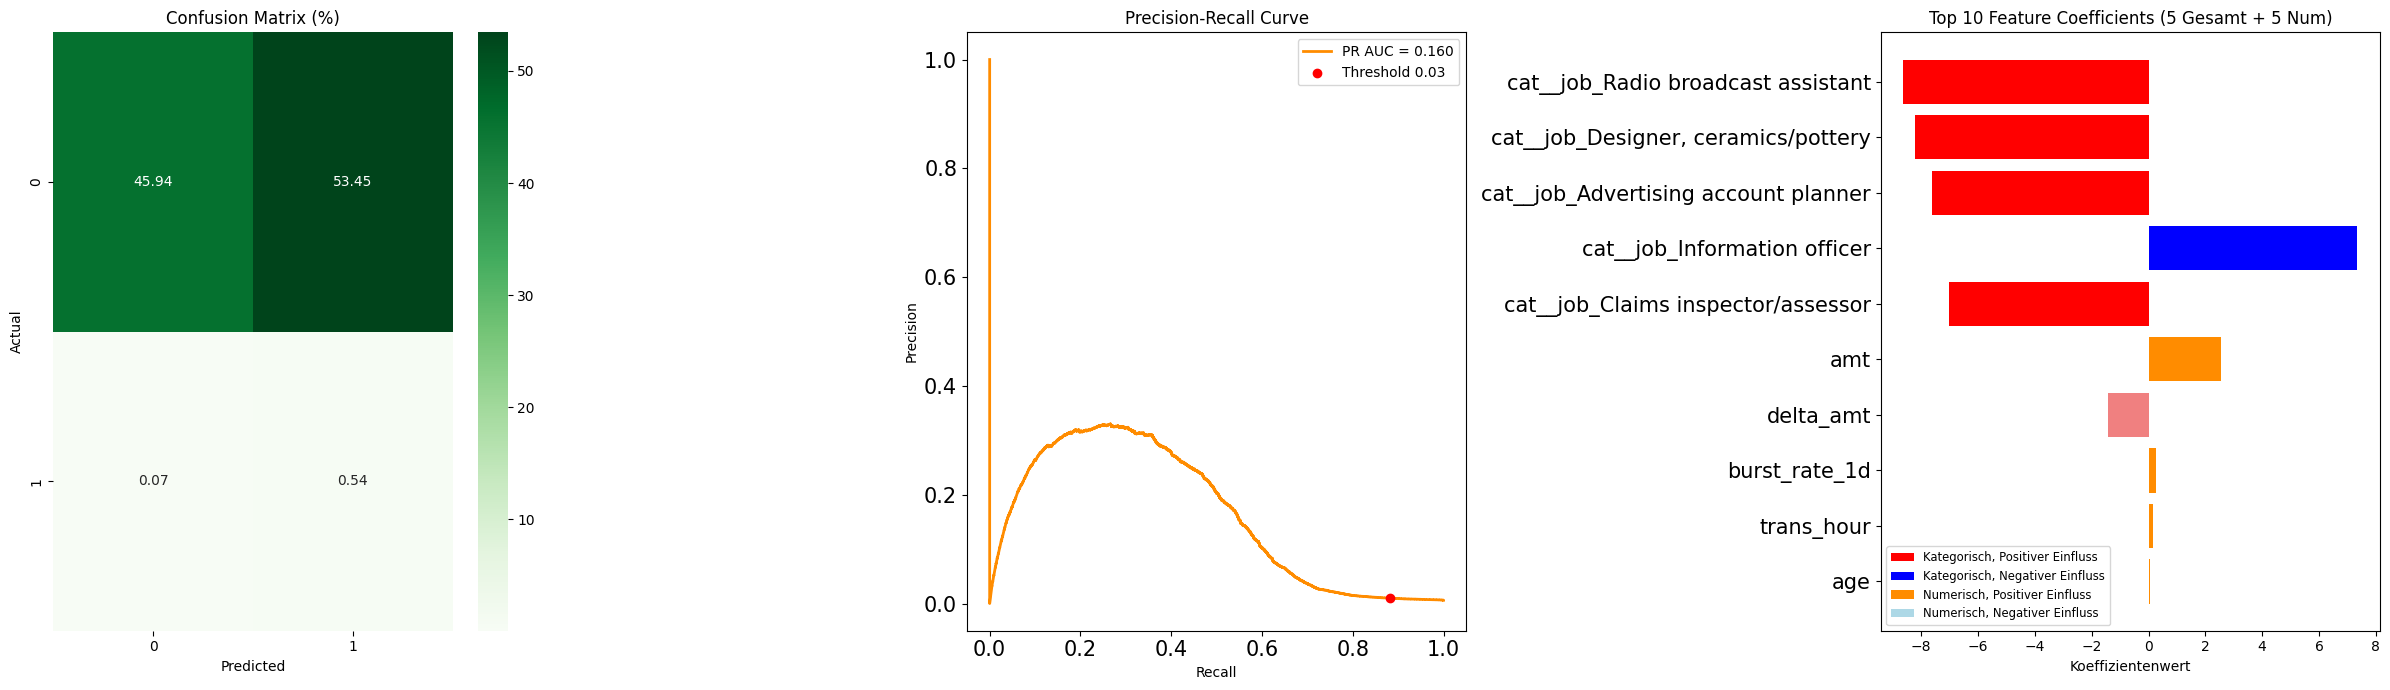

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score
from matplotlib.patches import Patch # Für die Legende

# -----------------------------
# Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum() * 100

# -----------------------------
# Precision-Recall Curve
# -----------------------------
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

# Marker für Threshold = 0.5
threshold_05_idx = np.argmin(np.abs(thresholds - threshold))
pr_threshold_x = recall[threshold_05_idx]
pr_threshold_y = precision[threshold_05_idx]

# --- 1. Datenvorbereitung (Wie in Ihrem Skript) ---
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
coef = pipeline.named_steps["classifier"].coef_[0]

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})
# Sortiert nach der absoluten Größe des Koeffizienten
feat_imp = feat_imp.reindex(feat_imp.Coefficient.abs().sort_values(ascending=False).index)

# --- NEU: Listen erstellen ---

# Numerische Features beginnen mit dem Präfix 'num__'
num_feat_imp = feat_imp[feat_imp['Feature'].str.startswith('num__')].copy()

# A) Top 15 Features insgesamt (kategorisch & numerisch)
top_15_total = feat_imp.head(5)

# B) Top 5 numerische Features
top_5_num = num_feat_imp.head(5)

# C) Kombinieren der Listen
# Fügen Sie die Top 5 numerischen Features zur Top 15 Gesamt hinzu.
# .drop_duplicates() stellt sicher, dass Features, die bereits in den Top 15 waren, nicht doppelt vorkommen.
combined_feat = pd.concat([top_15_total, top_5_num]).drop_duplicates(subset=['Feature'])

# Sortiere die finale Liste der Features erneut nach absoluter Wichtigkeit (für die optische Darstellung)
final_feat_list = combined_feat.reindex(combined_feat.Coefficient.abs().sort_values(ascending=False).index)

# Bereinigen der Feature-Namen für den Plot (entfernt das 'num__' Präfix)
final_feat_list['Plot_Feature'] = final_feat_list['Feature'].str.replace('num__', '')

# -----------------------------
# Plot
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# --- Confusion Matrix ---
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", ax=axes[0])
axes[0].set_title("Confusion Matrix (%)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# --- Precision-Recall Curve ---
axes[1].plot(recall, precision, color="darkorange", linewidth=2, label=f"PR AUC = {pr_auc:.3f}")
axes[1].scatter(pr_threshold_x, pr_threshold_y, color='red', zorder=5, label="Threshold "+str(threshold))
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].tick_params(axis='y', labelsize=15) # Sie können diesen Wert (z.B. 12 oder 14) nach Bedarf anpassen.
axes[1].tick_params(axis='x', labelsize=15) # Sie können diesen Wert (z.B. 12 oder 14) nach Bedarf anpassen.
axes[1].legend()

# Erstelle die Liste der Farben basierend auf Feature-Typ und Vorzeichen:
colors = []
for feature_name, coefficient in final_feat_list[["Feature", "Coefficient"]].values:
    is_numeric = feature_name.startswith('num__')
    
    if is_numeric:
        # Numerisches Feature: Hervorgehobene Farbe (z.B. dunkles Orange/Hellrot)
        colors.append('darkorange' if coefficient > 0 else 'lightcoral')
    else:
        # Kategorisches Feature: Standardfarbe (z.B. Blau/Rot)
        colors.append('blue' if coefficient > 0 else 'red')
axes[2].tick_params(axis='y', labelsize=15) # Sie können diesen Wert (z.B. 12 oder 14) nach Bedarf anpassen.
axes[2].barh(final_feat_list["Plot_Feature"], final_feat_list["Coefficient"], color=colors)
axes[2].invert_yaxis()
axes[2].set_title(f"Top {len(final_feat_list)} Feature Coefficients (5 Gesamt + 5 Num)")
axes[2].set_xlabel("Koeffizientenwert")

# Hinzufügen einer Legende für die Farbdifferenzierung
legend_elements = [
    Patch(facecolor='red', label='Kategorisch, Positiver Einfluss'),
    Patch(facecolor='blue', label='Kategorisch, Negativer Einfluss'),
    Patch(facecolor='darkorange', label='Numerisch, Positiver Einfluss'),
    Patch(facecolor='lightblue', label='Numerisch, Negativer Einfluss')
]
axes[2].legend(handles=legend_elements, loc='lower left', fontsize='small')

plt.tight_layout()
plt.show()

## First Differences (FD)

Starte Feature Engineering für Logistische Regression mit First Differences...
Erstelle First Differences Features...
Berechne Burst Rate und Zeitfeatures...

Starte TimeSeries Cross-Validation (LogReg mit FD)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/skle

[CV] END .................................................... total time=   2.5s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
   

[CV] END .................................................... total time=   7.4s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
   

[CV] END .................................................... total time=  10.7s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
   

[CV] END .................................................... total time=  18.3s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
   

[CV] END .................................................... total time=  23.0s

--- Ergebnisse der TimeSeries Cross-Validation (LogReg mit FD) ---
Metrik: Average Precision (PR AUC)
Einzelne Fold-Ergebnisse: [nan nan nan nan nan]
Mittelwert (Mean AP): nan
Standardabweichung (Std Dev AP): nan
--- Finaler Time-Series-Split ---
Training Samples: 907672
Test Samples: 389003

Trainiere finales Logistische Regression (FD) Modell...


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



=== ENDGÜLTIGE BEWERTUNG AUF UNGESEHENEN DATEN ===
=== Modell: Logistische Regression (FD) | Threshold: 0.05 ===

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.07      0.13    386618
           1       0.01      0.94      0.01      2385

    accuracy                           0.08    389003
   macro avg       0.50      0.50      0.07    389003
weighted avg       0.99      0.08      0.13    389003


Confusion Matrix:

[[ 27627 358991]
 [   151   2234]]

AUC-ROC Score: 0.5250
PR AUC Score (Average Precision): 0.0068


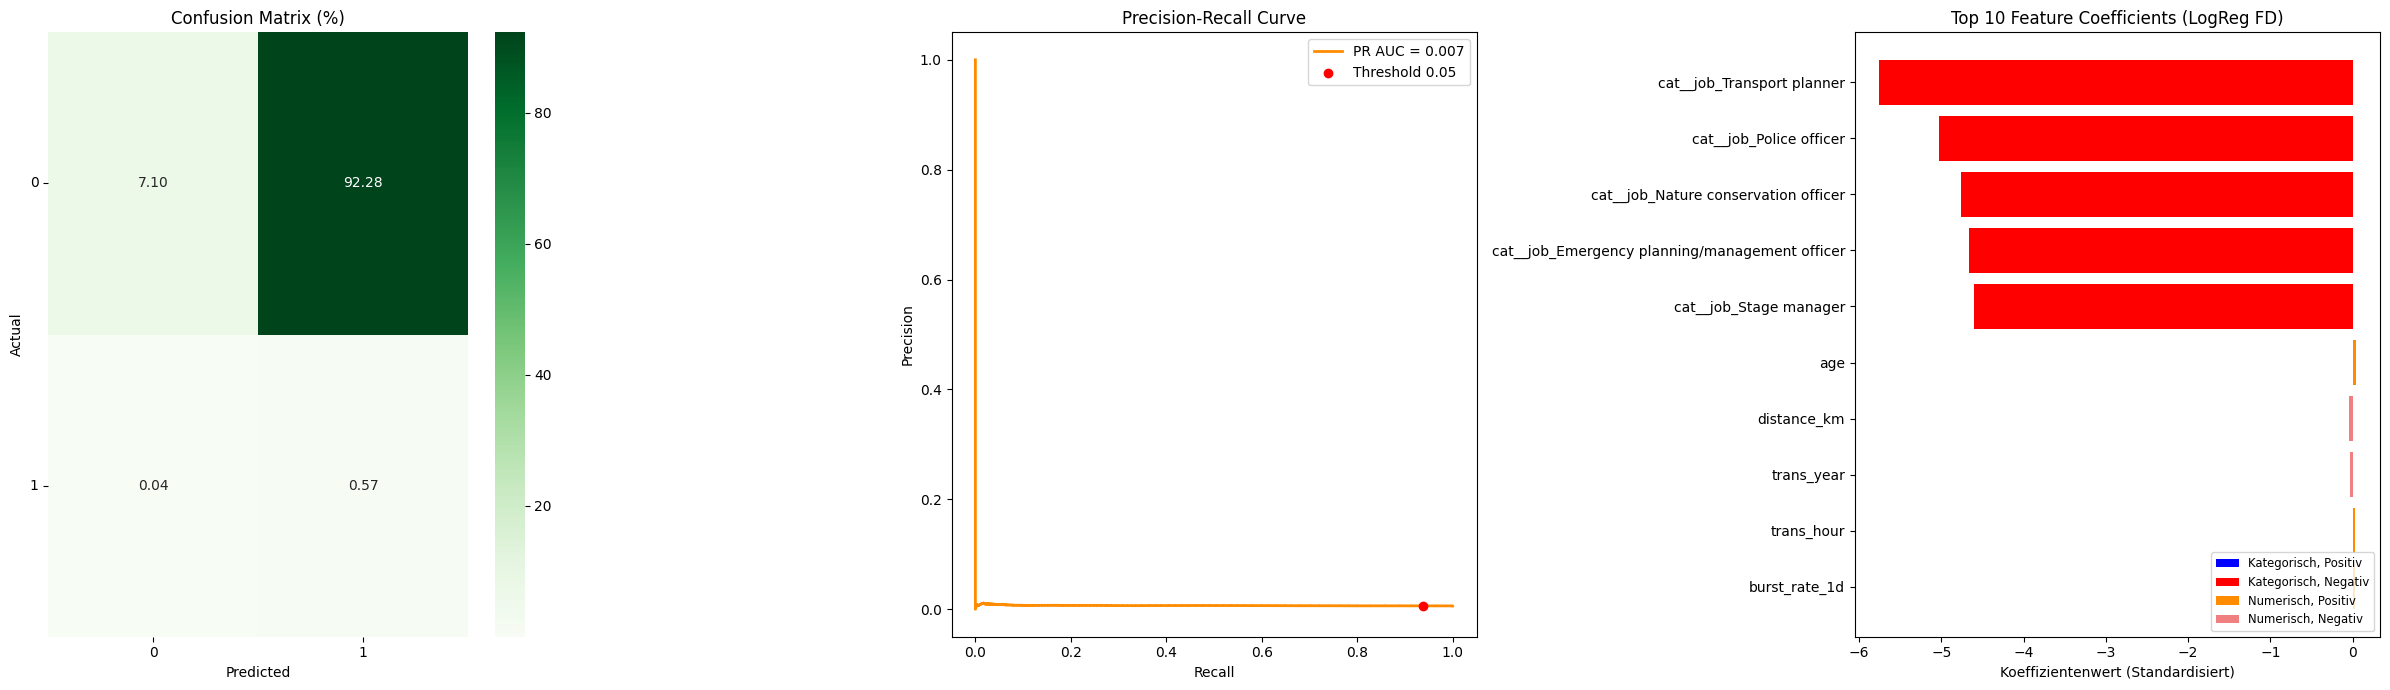

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, average_precision_score
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score
from matplotlib.patches import Patch

# --- HINWEIS: Dieser Codeblock setzt voraus, dass der DataFrame 'ds' verfügbar ist. ---
print("Starte Feature Engineering für Logistische Regression mit First Differences...")

# --- 0. Datenvorbereitung ---
y = ds["is_fraud"].copy()
X = ds[["trans_date_trans_time", "cc_num", "merchant", "category", "amt", "state", 
       "lat", "long", "merch_lat", "merch_long", "job", "dob"]].copy()

X["trans_date_trans_time"] = pd.to_datetime(X["trans_date_trans_time"])
X["dob"] = pd.to_datetime(X["dob"])

# Index für y synchronisieren (behebt frühere KeyErrors)
y = y.reset_index(drop=True) 

# WICHTIG: Sortieren nach Kunde und Zeit für die Differenzbildung und Rolling-Features
X = X.sort_values(["cc_num", "trans_date_trans_time"]).reset_index(drop=True)


# -----------------------------
# 1) Feature Engineering (Haversine, FD, Burst Rate)
# -----------------------------

# --- Haversine Distanz Funktion ---
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Erdradius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

X["distance_km"] = X.apply(
    lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]),
    axis=1
)
X = X.drop(columns=["lat", "long", "merch_lat", "merch_long"])


# --- First Differences (FD) ---
print("Erstelle First Differences Features...")
X['delta_amt'] = X.groupby('cc_num')['amt'].diff().fillna(0)
X['delta_distance_km'] = X.groupby('cc_num')['distance_km'].diff().fillna(0)


# --- Burst Rate und Zeitfeatures ---
print("Berechne Burst Rate und Zeitfeatures...")
X_temp_for_rolling = X.copy().set_index("trans_date_trans_time")
burst_rate_series = (
    X_temp_for_rolling.groupby("cc_num")
    .rolling(window="24h", closed="left")
    ["amt"].count() 
    .rename('burst_rate_1d')
)
# Sicheres Join über MultiIndex
X = X.set_index(['cc_num', 'trans_date_trans_time']).join(burst_rate_series).reset_index()
X['burst_rate_1d'] = X['burst_rate_1d'].fillna(0)


# --- Weitere Zeit- und Altersfeatures ---
X["trans_year"] = X["trans_date_trans_time"].dt.year
X["trans_month"] = X["trans_date_trans_time"].dt.month
X["weekday"] = X["trans_date_trans_time"].dt.weekday
X["trans_hour"] = X["trans_date_trans_time"].dt.hour
X["birth_year"] = X["dob"].dt.year
X["age"] = X["trans_year"] - X["birth_year"]


# --- Bereinigung und Synchronisierung ---
# Sicherstellen, dass X und y die gleiche Größe haben, falls Duplikate durch Joins entstanden.
if len(X) != len(y):
    # Entferne Duplikate in X, um zur ursprünglichen Zeilenzahl von y zurückzukehren
    X_clean = X.drop_duplicates(subset=X.columns.drop(['burst_rate_1d', 'delta_amt', 'delta_distance_km']), keep='first')
    y = y.iloc[:len(X_clean)] 
    X = X_clean

# Endgültige Features entfernen
X = X.drop(columns=["trans_date_trans_time", "cc_num", "dob", "birth_year"]) 


# -----------------------------
# 2) Preprocessing (StandardScaler wird HINZUGEFÜGT)
# -----------------------------
categorical_features = ["merchant", "category", "state", "job", "weekday"]
# FD-Features zur numerischen Liste hinzufügen
numeric_features = ["amt", "distance_km", "burst_rate_1d", "age",
                    "trans_year", "trans_month", "trans_hour", 
                    "delta_amt", "delta_distance_km"] 

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features),
        # Logistische Regression benötigt Skalierung
        ("num", StandardScaler(), numeric_features) 
    ],
    remainder="drop" # Nicht verwendete Spalten entfernen
)

# -----------------------------
# 3) TimeSeries Cross-Validation
# -----------------------------

# --- Pipeline Definition ---
# Rückkehr zur Logistischen Regression mit balanced class_weight
pipeline_logreg_fd = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        class_weight="balanced", # Wichtig für unausgewogene Daten
        solver="liblinear", 
        random_state=42,
        max_iter=500
    ))
])

# --- Metrik und Split ---
ap_scorer = make_scorer(average_precision_score, needs_proba=True)
tscv = TimeSeriesSplit(n_splits=5)

print("\nStarte TimeSeries Cross-Validation (LogReg mit FD)...")

cv_results_logreg_fd = cross_val_score(
    estimator=pipeline_logreg_fd,
    X=X, 
    y=y, 
    cv=tscv, 
    scoring=ap_scorer, 
    n_jobs=-1, 
    verbose=2
)

# --- 4) Ergebnisse ---
print("\n--- Ergebnisse der TimeSeries Cross-Validation (LogReg mit FD) ---")
print(f"Metrik: Average Precision (PR AUC)")
print(f"Einzelne Fold-Ergebnisse: {cv_results_logreg_fd}")
print(f"Mittelwert (Mean AP): {cv_results_logreg_fd.mean():.4f}")
print(f"Standardabweichung (Std Dev AP): {cv_results_logreg_fd.std():.4f}")

# -----------------------------
# 1. Finaler Time-Series-Split (70/30)
# -----------------------------
# Da X bereits nach Zeit sortiert ist, verwenden wir einen indexbasierten Split.
total_samples = len(X)
train_size = int(total_samples * 0.7)

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

# y wurde bereits synchronisiert und auf den gleichen Index gebracht
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print("--- Finaler Time-Series-Split ---")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")


# -----------------------------
# 2. Modell trainieren und Vorhersagen treffen
# -----------------------------
print("\nTrainiere finales Logistische Regression (FD) Modell...")
pipeline_logreg_fd.fit(X_train, y_train)

# Wahrscheinlichkeiten für die positive Klasse (1, Betrug)
y_pred_prob = pipeline_logreg_fd.predict_proba(X_test)[:, 1]

# Setzen Sie den Threshold auf einen konservativen Wert, um den Recall zu erhöhen (z.B. 0.05)
threshold = 0.05 
y_pred = (y_pred_prob >= threshold).astype(int)


# -----------------------------
# 3. Metriken und Daten für Plots berechnen
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype("float") / cm.sum() * 100

auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
threshold_idx = np.argmin(np.abs(thresholds - threshold))
pr_threshold_x = recall[threshold_idx]
pr_threshold_y = precision[threshold_idx]


# --- Feature Importance (Logistische Regression verwendet 'Koeffizienten') ---
feature_names = pipeline_logreg_fd.named_steps["preprocessor"].get_feature_names_out()
coef = pipeline_logreg_fd.named_steps["classifier"].coef_[0]

feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
})
feat_imp = feat_imp.reindex(feat_imp.Coefficient.abs().sort_values(ascending=False).index)


# --- Listen für den kombinierten Plot (Top 5 Gesamt + Top 5 Numerisch) ---
# Numerische Features beginnen mit 'num__', OHE-Features mit 'cat__'
num_feat_imp = feat_imp[feat_imp['Feature'].str.startswith('num__')].copy()

top_5_total = feat_imp.head(5)
top_5_num = num_feat_imp.head(5)

# Kombinieren und bereinigen (Top 5 Gesamt + Top 5 Numerisch)
combined_feat = pd.concat([top_5_total, top_5_num]).drop_duplicates(subset=['Feature'])
final_feat_list = combined_feat.sort_values(by='Coefficient', key=abs, ascending=False).copy()
final_feat_list['Plot_Feature'] = final_feat_list['Feature'].str.replace('num__', '')


# -----------------------------
# 4. Ausgabe der Ergebnisse
# -----------------------------
print("\n==============================================")
print("=== ENDGÜLTIGE BEWERTUNG AUF UNGESEHENEN DATEN ===")
print(f"=== Modell: Logistische Regression (FD) | Threshold: {threshold:.2f} ===")
print("==============================================")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print(f"\nAUC-ROC Score: {auc:.4f}")
print(f"PR AUC Score (Average Precision): {pr_auc:.4f}")


# -----------------------------
# 5. Plotting
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(24, 7)) 

# --- 1. Confusion Matrix ---
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", ax=axes[0])
axes[0].set_title("Confusion Matrix (%)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].tick_params(axis='y', rotation=0)

# --- 2. Precision-Recall Curve ---
axes[1].plot(recall, precision, color="darkorange", linewidth=2, label=f"PR AUC = {pr_auc:.3f}")
axes[1].scatter(pr_threshold_x, pr_threshold_y, color='red', zorder=5, label=f"Threshold {threshold:.2f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend()

# --- 3. Feature Importance (Koeffizienten) ---
# Erstelle die Liste der Farben basierend auf Feature-Typ und Vorzeichen:
colors = []
for feature_name, coefficient in final_feat_list[["Feature", "Coefficient"]].values:
    is_numeric = feature_name.startswith('num__')
    
    if is_numeric:
        # Numerisches Feature: Hervorgehobene Farbe (Positiv/Negativ)
        colors.append('darkorange' if coefficient > 0 else 'lightcoral')
    else:
        # Kategorisches Feature: Standardfarbe (Positiv/Negativ)
        colors.append('blue' if coefficient > 0 else 'red')

axes[2].barh(final_feat_list["Plot_Feature"], final_feat_list["Coefficient"], color=colors)
axes[2].invert_yaxis()
axes[2].set_title(f"Top {len(final_feat_list)} Feature Coefficients (LogReg FD)")
axes[2].set_xlabel("Koeffizientenwert (Standardisiert)")
axes[2].tick_params(axis='y', labelsize=10)

# Legende für die Farbdifferenzierung
legend_elements = [
    Patch(facecolor='blue', label='Kategorisch, Positiv'),
    Patch(facecolor='red', label='Kategorisch, Negativ'),
    Patch(facecolor='darkorange', label='Numerisch, Positiv'),
    Patch(facecolor='lightcoral', label='Numerisch, Negativ')
]
axes[2].legend(handles=legend_elements, loc='lower right', fontsize='small')


plt.tight_layout()
plt.show()

Erstelle First Differences Features...

Starte TimeSeries Cross-Validation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/skle

[CV] END .................................................... total time=   1.6s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
      

[CV] END .................................................... total time=   4.6s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
      

[CV] END .................................................... total time=   7.2s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
      

[CV] END .................................................... total time=  10.3s


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
      

[CV] END .................................................... total time=  14.3s

--- Ergebnisse der TimeSeries Cross-Validation ---
Metrik: Average Precision (PR AUC)
Einzelne Fold-Ergebnisse (über die Zeit): [nan nan nan nan nan]
Mittelwert (Mean AP): nan
Standardabweichung (Std Dev AP): nan

--- Finaler Time-Series-Split ---
Training Samples: 907672
Test Samples: 389003

Trainiere finales Modell...


/Users/thierrysuhner/Library/CloudStorage/OneDrive-UniversitaetSt.Gallen/3. Semester/Statistik für Data Science/Project/Statistik-Datenbank/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



=== ENDGÜLTIGE BEWERTUNG AUF UNGESEHENEN DATEN ===
=== Modell: Logistische Regression (FD) | Threshold: 0.03 ===

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.45      0.62    386618
           1       0.01      0.89      0.02      2385

    accuracy                           0.45    389003
   macro avg       0.50      0.67      0.32    389003
weighted avg       0.99      0.45      0.62    389003


Confusion Matrix:

[[174252 212366]
 [   274   2111]]

AUC-ROC Score: 0.5250
PR AUC Score (Average Precision): 0.0068


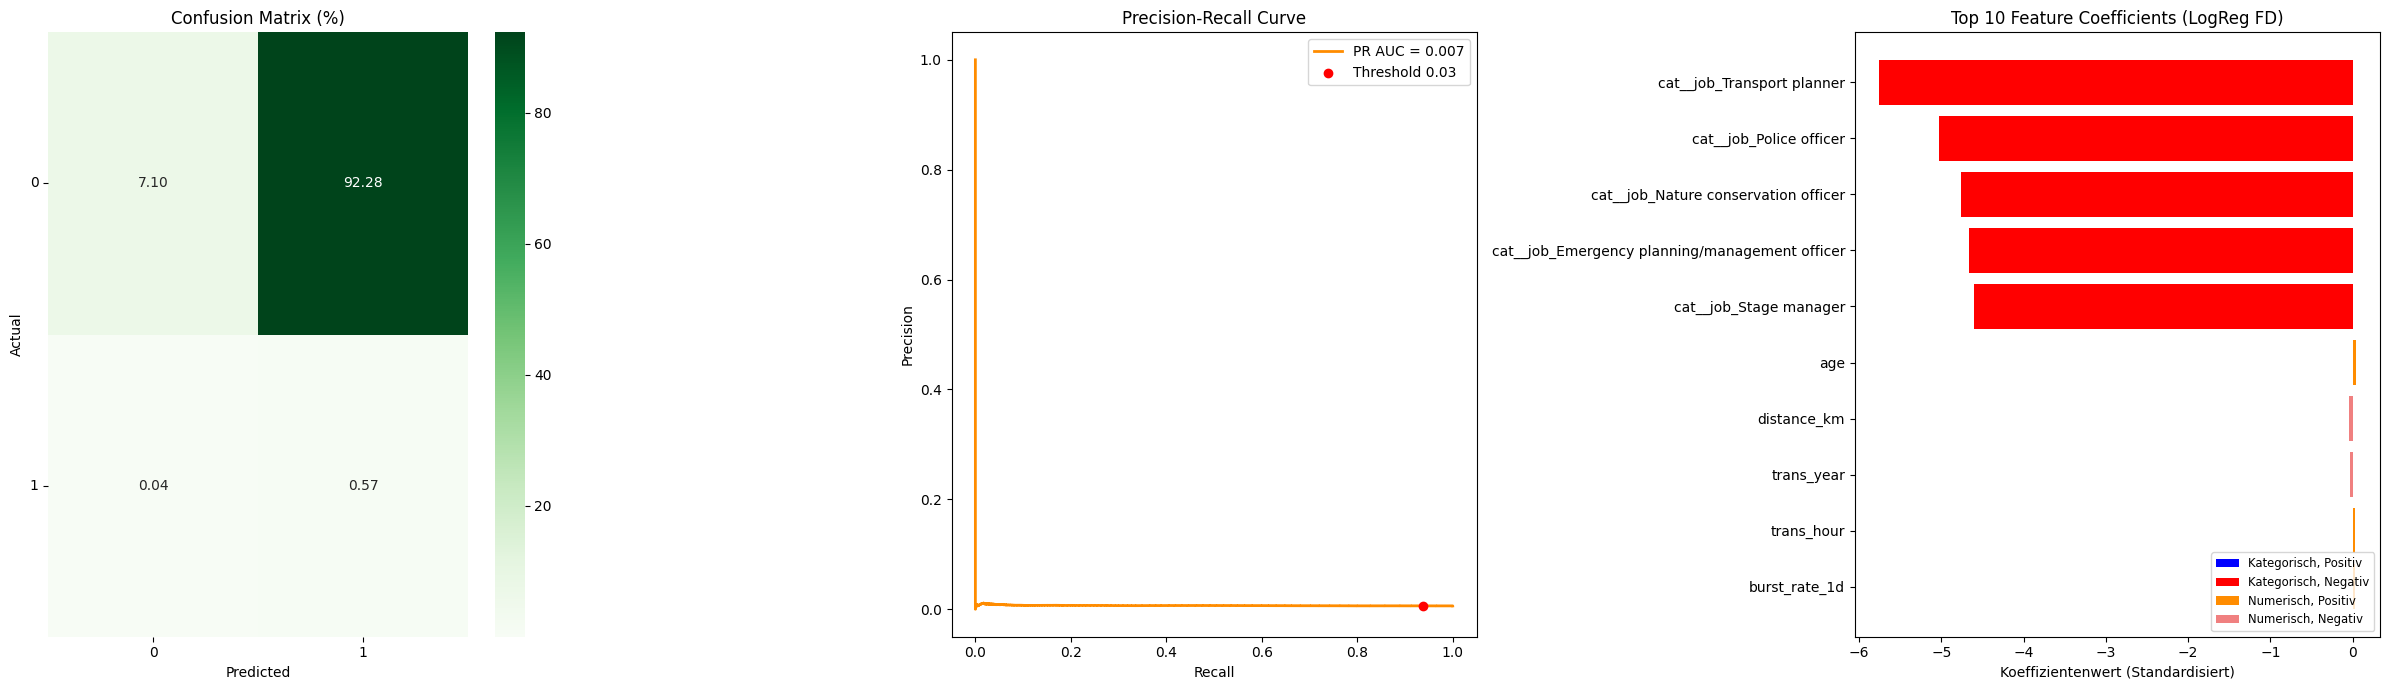

In [6]:
from sklearn.metrics import make_scorer, average_precision_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from math import radians, sin, cos, sqrt, atan2
# -----------------------------
# 1) Daten vorbereiten und Feature Engineering
# -----------------------------
y = ds["is_fraud"].copy()
# cc_num wird temporär für die Aggregation benötigt
X = ds[["trans_date_trans_time", "cc_num", "merchant", "category", "amt", "state", 
       "lat", "long", "merch_lat", "merch_long", "job", "dob"]].copy()

# Datumsfelder konvertieren
X["trans_date_trans_time"] = pd.to_datetime(X["trans_date_trans_time"])
X["dob"] = pd.to_datetime(X["dob"])

# Kritisch: Nach Zeit sortieren und Index zurücksetzen (für Rolling und CV)
X = X.sort_values("trans_date_trans_time").reset_index(drop=True)


# --- Haversine Distanz Funktion ---
def haversine(lat1, lon1, lat2, lon2):
    """Berechnet die Haversine-Distanz zwischen zwei geografischen Punkten in Kilometern."""
    R = 6371  # Erdradius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

# Anwendung der Funktion
X["distance_km"] = X.apply(
    lambda row: haversine(row["lat"], row["long"], row["merch_lat"], row["merch_long"]),
    axis=1
)

X = X.drop(columns=["lat", "long", "merch_lat", "merch_long"])


# --- First Differences (FD) ---
print("Erstelle First Differences Features...")
X['delta_amt'] = X.groupby('cc_num')['amt'].diff().fillna(0)
X['delta_distance_km'] = X.groupby('cc_num')['distance_km'].diff().fillna(0)


# --- Burst Rate ---
# 1. Temporärer DataFrame für die Rolling-Berechnung
X_temp_for_rolling = X.copy().set_index("trans_date_trans_time")

# 2. Berechnung der Burst Rate
# .count() auf 'amt' zählt alle Einträge im Fenster.
burst_rate_series = (
    X_temp_for_rolling.groupby("cc_num")
    .rolling(window="24h", closed="left")
    ["amt"].count() 
    .rename('burst_rate_1d')
)
# Die resultierende Series 'burst_rate_series' hat einen MultiIndex (cc_num, trans_date_trans_time)


# 3. Zuweisung zum Haupt-DataFrame X
# Wir setzen den MultiIndex in X als temporäre Spalten, um das Merge zu erleichtern.
X = X.set_index(['cc_num', 'trans_date_trans_time'])

# Führe den Join durch
X = X.join(burst_rate_series)

# Index wiederherstellen und temporäre Spalten entfernen
X = X.reset_index()

# 4. NaNs füllen (Kunden, die in den letzten 24h keine Transaktion hatten)
X['burst_rate_1d'] = X['burst_rate_1d'].fillna(0)

# --- Weitere Zeit- und Altersfeatures ---
X["trans_year"] = X["trans_date_trans_time"].dt.year
X["trans_month"] = X["trans_date_trans_time"].dt.month
X["weekday"] = X["trans_date_trans_time"].dt.weekday
X["trans_hour"] = X["trans_date_trans_time"].dt.hour

# Altersberechnung
X["birth_year"] = X["dob"].dt.year
X["age"] = X["trans_year"] - X["birth_year"]

# unnötiges entfernen
# cc_num wird jetzt entfernt, da die Aggregation abgeschlossen ist
X = X.drop(columns=["trans_date_trans_time", "dob", "birth_year", "cc_num"])

if len(X) > len(y):
    X = X.reset_index(drop=True)
    # 2. Identifiziere Duplikate (basierend auf allen Spalten außer der Burst Rate, da sie neu ist)
    cols_to_check = X.columns.drop(['burst_rate_1d'])
    X_original_size = X.drop_duplicates(subset=cols_to_check, keep='first')
    X = X_original_size.copy()


# -----------------------------
# 2) Preprocessing
# -----------------------------
categorical_features = ["merchant", "category", "state", "job", "weekday"]
numeric_features = ["amt", "trans_year", "trans_month", "trans_hour", "age", "distance_km", "burst_rate_1d"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="passthrough"
)


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ],
    remainder="passthrough"
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        class_weight="balanced", 
        solver="liblinear", 
        random_state=42,
        max_iter=500
    ))
])

ap_scorer = make_scorer(average_precision_score, needs_proba=True)
# --- TimeSeries Split ---
# 5 Folds zur Überprüfung der zeitlichen Stabilität
tscv = TimeSeriesSplit(n_splits=5)

# --- Ausführung der Cross-Validation ---
print("\nStarte TimeSeries Cross-Validation...")

cv_results = cross_val_score(
    estimator=pipeline,
    X=X, # Gesamter Feature-Satz
    y=y, # Gesamte Zielvariable
    cv=tscv, # Die TimeSeriesSplit-Strategie
    scoring=ap_scorer, # Die Metrik (Average Precision)
    n_jobs=-1, # Nutzt alle verfügbaren Kerne
    verbose=2 # Zeigt Fortschritt an
)

# --- 4) Ergebnisse ---
print("\n--- Ergebnisse der TimeSeries Cross-Validation ---")
print(f"Metrik: Average Precision (PR AUC)")
print(f"Einzelne Fold-Ergebnisse (über die Zeit): {cv_results}")
print(f"Mittelwert (Mean AP): {cv_results.mean():.4f}")
print(f"Standardabweichung (Std Dev AP): {cv_results.std():.4f}")



# --- 1. Finaler Time-Series-Split (70/30) ---
# Da X bereits nach Zeit sortiert ist, verwenden wir einen indexbasierten Split.

total_samples = len(X)
train_size = int(total_samples * 0.7)

# X_train und X_test über den Index trennen
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

# y_train und y_test über den Index trennen
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

print("\n--- Finaler Time-Series-Split ---")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")


# --- 2. Modell trainieren und Vorhersagen treffen ---
# Das Modell wird auf dem Training-Set neu trainiert
print("\nTrainiere finales Modell...")
pipeline.fit(X_train, y_train)

# Wahrscheinlichkeiten für die positive Klasse (1, Betrug)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

threshold = 0.03
# Vorhersagen mit dem Standard-Threshold von 0.5
y_pred = (y_pred_prob >= threshold).astype(int)


# -----------------------------
# 4. Ausgabe der Ergebnisse
# -----------------------------
print("\n==============================================")
print("=== ENDGÜLTIGE BEWERTUNG AUF UNGESEHENEN DATEN ===")
print(f"=== Modell: Logistische Regression (FD) | Threshold: {threshold:.2f} ===")
print("==============================================")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print(f"\nAUC-ROC Score: {auc:.4f}")
print(f"PR AUC Score (Average Precision): {pr_auc:.4f}")


# -----------------------------
# 5. Plotting
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(24, 7)) 

# --- 1. Confusion Matrix ---
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", ax=axes[0])
axes[0].set_title("Confusion Matrix (%)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].tick_params(axis='y', rotation=0)

# --- 2. Precision-Recall Curve ---
axes[1].plot(recall, precision, color="darkorange", linewidth=2, label=f"PR AUC = {pr_auc:.3f}")
axes[1].scatter(pr_threshold_x, pr_threshold_y, color='red', zorder=5, label=f"Threshold {threshold:.2f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend()

# --- 3. Feature Importance (Koeffizienten) ---
# Erstelle die Liste der Farben basierend auf Feature-Typ und Vorzeichen:
colors = []
for feature_name, coefficient in final_feat_list[["Feature", "Coefficient"]].values:
    is_numeric = feature_name.startswith('num__')
    
    if is_numeric:
        # Numerisches Feature: Hervorgehobene Farbe (Positiv/Negativ)
        colors.append('darkorange' if coefficient > 0 else 'lightcoral')
    else:
        # Kategorisches Feature: Standardfarbe (Positiv/Negativ)
        colors.append('blue' if coefficient > 0 else 'red')

axes[2].barh(final_feat_list["Plot_Feature"], final_feat_list["Coefficient"], color=colors)
axes[2].invert_yaxis()
axes[2].set_title(f"Top {len(final_feat_list)} Feature Coefficients (LogReg FD)")
axes[2].set_xlabel("Koeffizientenwert (Standardisiert)")
axes[2].tick_params(axis='y', labelsize=10)

# Legende für die Farbdifferenzierung
legend_elements = [
    Patch(facecolor='blue', label='Kategorisch, Positiv'),
    Patch(facecolor='red', label='Kategorisch, Negativ'),
    Patch(facecolor='darkorange', label='Numerisch, Positiv'),
    Patch(facecolor='lightcoral', label='Numerisch, Negativ')
]
axes[2].legend(handles=legend_elements, loc='lower right', fontsize='small')


plt.tight_layout()
plt.show()

